In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qpsolvers import solve_qp

plt.rcParams.update({
    "text.usetex": True, 
    'text.latex.preamble': r'\usepackage{amsfonts}'})

In [2]:
def active_set(y):
    len_active_set = y.shape[0]
    active_set = [[y[i], 1.0, [i, ]]
                  for i in range(len_active_set)]
    current = 0

    while current < len_active_set - 1:
        while current < len_active_set -1 and \
              (active_set[current][0] * active_set[current + 1][1] <= 
               active_set[current][1] * active_set[current + 1][0]):
            current += 1

        if current == len_active_set - 1:
            break

        # merge two groups
        active_set[current][0] += active_set[current + 1][0]
        active_set[current][1] += active_set[current + 1][1]
        active_set[current][2] += active_set[current + 1][2]

        active_set.pop(current + 1)
        len_active_set -= 1
        while current > 0 and \
              (active_set[current - 1][0] * active_set[current][1] > 
               active_set[current - 1][1] * active_set[current][0]):
            current -= 1
            active_set[current][0] += active_set[current + 1][0]
            active_set[current][1] += active_set[current + 1][1]
            active_set[current][2] += active_set[current + 1][2]

            active_set.pop(current + 1)
            len_active_set -= 1

    solution = np.zeros_like(y)
    for v, w, idx in active_set:
        solution[idx] = v / w
    return solution


def pava(y):
    n = y.shape[0]
    # The algorithm proceeds by iteratively updating the solution
    # array.

    solution = y.copy()

    if n <= 1:
        return solution

    n -= 1
    while 1:
        # repeat until there are no more adjacent violators.
        i = 0
        pooled = 0
        while i < n:
            k = i
            while k < n and solution[k] >= solution[k + 1]:
                k += 1
            if solution[i] != solution[k]:
                # solution[i:k + 1] is a decreasing subsequence, so
                # replace each point in the subsequence with the
                # weighted average of the subsequence.
                numerator = 0.0
                denominator = 0.0
                for j in range(i, k + 1):
                    numerator += solution[j]
                    denominator += 1
                for j in range(i, k + 1):
                    solution[j] = numerator / denominator
                pooled = 1
            i = k + 1
        # Check for convergence
        if pooled == 0:
            break

    return solution

def proj_spline(y, metric, constraints_mat, cons_rhs):
    return solve_qp(
        metric * 2,
        -2 * np.dot(metric, y),
        constraints_mat, cons_rhs)

In [3]:
from pwass.spline import SplineBasis

xgrid = np.linspace(-4, 4, 1000)
y = xgrid**3 - 4 * xgrid

spbasis = SplineBasis(2, xgrid=xgrid, nbasis=20)
coeffs = spbasis.get_spline_expansion(y)

constraints_mat = np.zeros((spbasis.nbasis - 1, spbasis.nbasis))
for i in range(spbasis.nbasis-1):
    constraints_mat[i, i] = 1
    constraints_mat[i, i+1] = -1

cons_rhs = np.zeros((spbasis.nbasis-1,))

In [4]:
%%time
a_proj = active_set(y)

CPU times: user 1.07 ms, sys: 23 µs, total: 1.09 ms
Wall time: 1.09 ms


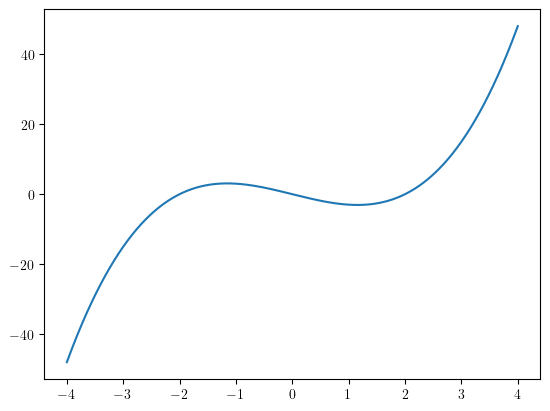

In [5]:
plt.plot(xgrid, y)
# plt.plot(xgrid, a_proj)

In [6]:
%%time
for i in range(1000):
    a_proj = pava(y)

CPU times: user 29.3 s, sys: 27.9 ms, total: 29.3 s
Wall time: 29.5 s


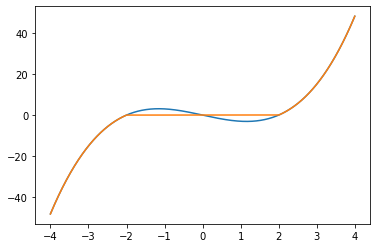

In [16]:
plt.plot(xgrid, y)
plt.plot(xgrid, a_proj)

In [ ]:
%%time
for i in range(1000):
    spline_proj = proj_spline(coeffs, spbasis.metric, constraints_mat, cons_rhs)

In [ ]:
plt.plot(xgrid, y)
plt.plot(xgrid, spbasis.eval_spline(spline_proj))

In [12]:
# Muller's boundary projection

reg_out = y - xgrid
for eta in np.linspace(1, 0, 1000):
    proj_m = eta * reg_out
    if np.all(np.diff(proj_m + xgrid) >= 0):
        break

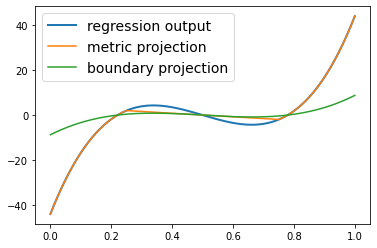

In [13]:
xgrid_new = np.linspace(0, 1, len(xgrid))

plt.plot(xgrid_new, reg_out, label="regression output", lw=2)
plt.plot(xgrid_new, a_proj - xgrid, label="metric projection")
plt.plot(xgrid_new, proj_m, label="boundary projection")
plt.legend(fontsize=14)
# plt.savefig("metric_boundary.pdf", bbox_inches="tight")
plt.show()

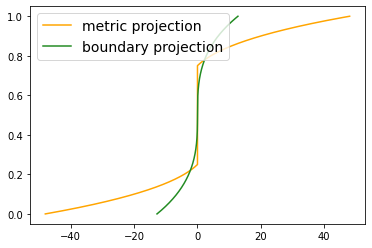

In [14]:
# plt.plot(reg_out + xgrid, xgrid_new, label="regression output", lw=2)
plt.plot(a_proj, xgrid_new,  label="metric projection", color="orange")
plt.plot(proj_m + xgrid, xgrid_new, label="boundary projection", color="forestgreen")
plt.legend(fontsize=14, loc="best")
# plt.savefig("metric_boundary_cdf.pdf", bbox_inches="tight")
plt.show()

In [21]:
push_cdf = np.loadtxt("pushforward_cdf.txt", delimiter=",")
push_grid = np.loadtxt("pushforward_grid.txt", delimiter=",")

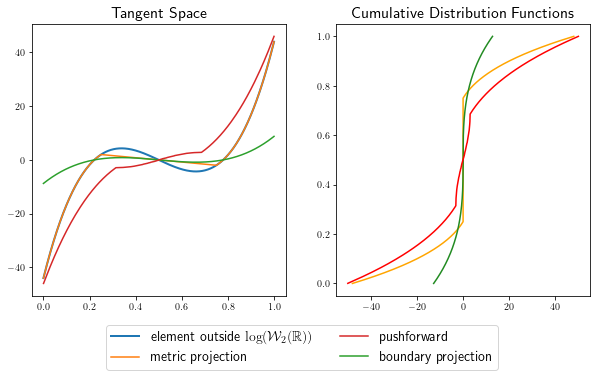

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(xgrid_new, reg_out, label=r"element outside $\log(\mathcal W_2(\mathbb R))$", lw=2)
axes[0].plot(xgrid_new, a_proj - xgrid, label="metric projection")
axes[0].plot(xgrid_new, proj_m, label="boundary projection")
axes[0].plot(push_cdf, push_grid - xgrid, label="pushforward")

axes[1].plot(a_proj, xgrid_new,  label="metric projection", color="orange")
axes[1].plot(proj_m + xgrid, xgrid_new, label="boundary projection", color="forestgreen")
axes[1].plot(push_grid, push_cdf, label="pushforward", color="red")

axes[0].set_title("Tangent Space", fontsize=16)
axes[1].set_title("Cumulative Distribution Functions", fontsize=16)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
unique_indexes = np.array([labels.index(x) for x in set(labels)])
lines = np.array(lines)[unique_indexes]
labels = np.array(labels)[unique_indexes]


fig.legend(lines, labels, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.1), fontsize=14)

# axes[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(1.1, -0.3), fontsize=14)
plt.savefig("metric_vs_boundary_vs_push.pdf", bbox_inches="tight")

plt.show()

In [29]:
labels

['regression output',
 'metric projection',
 'boundary projection',
 'metric projection',
 'boundary projection',
 'pushforward']